# Praktikum 2: Korrelationsanalyse

## Aufgabe: Korrelationsanalyse der YouTube Daten

- Nehmt die YouTube Daten aus dem 1. Praktikum
- Nutzt die bereinigten Daten aus Aufgabe 1 und exportiert sie als `parquet`-Datei. Tipp: nutzt die Funktion `to_parquet()`
- Sucht euch 2 Merkmale aus, die ihr auf Korrelation testen wollt
- Visualisiert die beiden Merkmale mit einem Scatter-Plot. Nutzt dafür `seaborn`
- Führt die Korrelationsanalyse mit dem passenden Algorithmus (Korrelationskoeffizienten) durch
- Nutzt dafür die Pandas-funktion `corr()`

- Interpretiert das Ergebnis

### Korrelationsanalyse der Dauer der Videos und der Anzahl der Kommentare

Es wird eine Analyse der Korrelation von 'duration' und 'comments' durchgeführt.
Zunächst werden die YouTube Daten bereinigt und als parquet-Datei exportiert.
Anschließend werden die Merkmale in einen Dataframe geladen, in numerische Werte umgewandelt (wobei NaN-Werte entfernt werden) und mittels Scatter-Plot visualisiert.
Danach werden die Korrelationskoeffizienten mit den entsprechenden Methoden berechnet und die Analyse interpretiert.

In [1]:
# pip aktualisieren & benötigte Libraries installieren
!pip install --upgrade pip 
!pip install pandas matplotlib seaborn pyarrow

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\adria\anaconda3\envs\ML\python.exe -m pip install --upgrade pip


In [1]:
# Importieren der benötigten Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Achtung

Die folgenden drei Zellen wurden nur einmalig ausgeführt, um die YouTube Daten zu bereinigen und als parquet-Datei abzuspeichern.

In [3]:
# Daten mit Pandas einlesen
youtube_data = pd.read_parquet('../Data/youtube_trend_videos.parquet')

In [4]:
# Umwandlung von Datums- und Zeitangaben in den Datentyp datetime. Dies ermöglicht die Durchführung von Datums- und Zeitoperationen. Dies erzeugt keine neuen Attribute, sondern ändert nur den Datentyp der vorhandenen Attribute.
youtube_data[['created', 'published_at', 'modified_at']] = youtube_data[
    ['created', 'published_at', 'modified_at']].apply(pd.to_datetime)
# Berechnung der Zeitdifferenz zwischen 'modified_at' und 'created' in Stunden. Dies zeigt, wie lange ein Video gebraucht hat, um in die Trends zu kommen.
youtube_data['trend_time_hours'] = (youtube_data['modified_at'] - youtube_data['created']) / pd.Timedelta(hours=1)
# Extrahiert den Wochentag (als Zahl von 0 bis 6, wobei 0 für Montag steht) aus dem 'created' Datum.
youtube_data['weekday'] = youtube_data['created'].dt.weekday
# Berechnung der Zeitdifferenz zwischen 'created' und 'published_at' in Stunden.
youtube_data['hours_until_trend'] = (youtube_data['created'] - youtube_data['published_at']) / pd.Timedelta(hours=1)
# Berechnung des Wachstums der Likes eines Videos, indem die Differenz zwischen dem letzten und dem ersten Wert in der 'likes'-Liste berechnet wird.
youtube_data['likes_growth'] = youtube_data['likes'].apply(
    lambda x: x[-1] - x[0] if x[0] is not None and x[-1] is not None else None)
# Berechnung des Wachstums der Likes eines Videos pro Stunde, indem das gesamte Likes-Wachstum durch die Anzahl der Stunden, die das Video benötigt hat, um in die Trends zu kommen, geteilt wird.
youtube_data['likes_growth/hour'] = youtube_data['likes_growth'] / youtube_data['trend_time_hours']
# Extrahiert den ersten Rang eines Videos aus der 'rank'-Liste.
youtube_data['first_rank'] = youtube_data['rank'].apply(lambda x: x[0])
# Extrahiert den besten (niedrigsten) Rang eines Videos aus der 'rank'-Liste.
youtube_data['best_rank'] = youtube_data['rank'].apply(lambda x: min(x))
# Berechnet das Wachstum der Views eines Videos, indem die Differenz zwischen dem letzten und dem ersten Wert in der 'views'-Liste berechnet wird.
youtube_data['views_growth'] = youtube_data['views'].apply(
    lambda x: x[-1] - x[0] if x[0] is not None and x[-1] is not None else None)
# Berechnet das Wachstum der Views eines Videos pro Stunde, indem das gesamte Views-Wachstum durch die Anzahl der Stunden, die das Video benötigt hat, um in die Trends zu kommen, geteilt wird.
youtube_data['views_growth/hour'] = youtube_data['views_growth'] / youtube_data['trend_time_hours']

# Erstellen neuer Spalten für die aktuellsten Werte von Titel, Views, Likes, Dislikes und Kommentaren
youtube_data['title'] = youtube_data['title'].apply(lambda x: x[-1])  # Die Titel-Spalte wird überschrieben
youtube_data['views_cleaned'] = youtube_data['views'].apply(lambda x: x[-1])
youtube_data['likes_cleaned'] = youtube_data['likes'].apply(lambda x: x[-1])
youtube_data['dislikes_cleaned'] = youtube_data['dislikes'].apply(lambda x: x[-1])
youtube_data['comments_cleaned'] = youtube_data['comments'].apply(lambda x: x[-1])

In [5]:
# Speichern der Daten im Parquet-Format
youtube_data.to_parquet("../Data/cleaned_youtube_data.parquet")

### Hier fortfahren

In [2]:
# Daten einlesen
df = pd.read_parquet("../Data/cleaned_youtube_data.parquet")

# Dataframe mit den gewünschten Spalten erstellen
df = df[['duration', 'comments_cleaned']]

In [3]:
# Überprüfen, ob die Daten NaN-Werte enthalten
missing_values = df.isnull().sum()
missing_values

duration              0
comments_cleaned    251
dtype: int64

In [4]:
# Konvertierung der Spalten 'duration' und 'comments' in numerische Werte
df['duration'] = pd.to_numeric(df['duration'], errors='coerce') / 1000
df['comments_cleaned'] = pd.to_numeric(df['comments_cleaned'], errors='coerce') / 1_000_000

# Datenbereinigung: Entfernen von NaN-Werten in 'duration' und 'comments'
df = df.dropna(subset=['duration', 'comments_cleaned'])

# Überprüfen, ob die Daten noch NaN-Werte enthalten
missing_values = df.isnull().sum()
missing_values

duration            0
comments_cleaned    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17700 entries, 0 to 17950
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration          17700 non-null  float64
 1   comments_cleaned  17700 non-null  float64
dtypes: float64(2)
memory usage: 414.8 KB


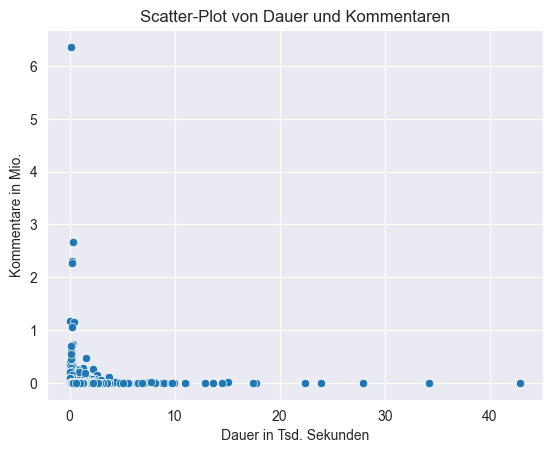

In [6]:
# Visualisierung der Korrelation mit einem Scatter-Plot
sns.scatterplot(data=df, x='duration', y='comments_cleaned')
plt.title('Scatter-Plot von Dauer und Kommentaren')
plt.xlabel('Dauer in Tsd. Sekunden')
plt.ylabel('Kommentare in Mio.')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [7]:
# Berechnung und Ausgabe der Korrelationskoeffizienten zwischen 'duration' und 'comments_cleaned'


# Berechnung des Pearson-Korrelationskoeffizienten
pearson_corr_matrix = df[['duration', 'comments_cleaned']].corr(method='pearson')
pearson_coefficient = pearson_corr_matrix.loc['duration', 'comments_cleaned']

# Berechnung des Kendall-Korrelationskoeffizienten
kendall_corr_matrix = df[['duration', 'comments_cleaned']].corr(method='kendall')
kendall_coefficient = kendall_corr_matrix.loc['duration', 'comments_cleaned']

# Berechnung des Spearman-Korrelationskoeffizienten
spearman_corr_matrix = df[['duration', 'comments_cleaned']].corr(method='spearman')
spearman_coefficient = spearman_corr_matrix.loc['duration', 'comments_cleaned']

# Ausgabe der Korrelationskoeffizienten
print("Korrelationskoeffizienten zwischen 'duration' und 'comments_cleaned':\n")
print(f"Pearson: {round(pearson_coefficient, 3)}")
print(f"Kendall: {round(kendall_coefficient, 3)}")
print(f"Spearman: {round(spearman_coefficient, 3)}")

ModuleNotFoundError: No module named 'scipy'

### Interpretation

- Der Pearson-Korrelationskoeffizient von -0,017 deutet auf eine extrem schwache negative lineare Korrelation zwischen Videodauer und Kommentaren hin. Der Wert liegt jedoch so nah an 0, dass man von keiner praktisch relevanten linearen Beziehung zwischen den beiden Variablen ausgehen kann.
- Der Kendall-Koeffizient von 0,043 misst die Rangkorrelation zwischen den Variablen. Auch dieser sehr geringe positive Wert bestätigt, dass praktisch keine monotone Beziehung vorliegt - längere Videos haben also nicht zwingend mehr oder weniger Kommentare als kürzere.
- Der Spearman-Koeffizient von 0,065 ist eine weitere Rangkorrelationsmaßzahl. Wie der Kendall-Koeffizient ist auch er positiv, aber nahe bei 0. Dies unterstreicht erneut den Mangel an einer systematischen Rangbeziehung.
Zusammengefasst deuten alle drei Korrelationskoeffizienten übereinstimmend auf eine äußerst schwache bis nicht vorhandene Beziehung zwischen Videodauer und Kommentarzahl hin - unabhängig davon, ob man eine lineare oder monotone Beziehung betrachtet.